<a href="https://colab.research.google.com/github/mynameislllyt/API_Experiment/blob/main/fenlei1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# ========================================
# 1. 导入必要的库
# ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示（如果需要）
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("✓ 库导入成功")

# ========================================
# 2. 上传数据文件
# ========================================
from google.colab import files
print("请上传CSV文件...")
uploaded = files.upload()

# 获取上传的文件名
filename = list(uploaded.keys())[0]
print(f"✓ 文件 '{filename}' 上传成功")

# 读取数据
df = pd.read_csv(filename)
print(f"\n数据集形状: {df.shape}")
print(f"样本数量: {len(df)}")
print(f"序列长度: {df.shape[1] - 2}")  # 减去hash和malware列
print("\n前3行预览:")
print(df.head(3))

# ========================================
# 3. 特征提取函数
# ========================================
def extract_load_features(sequence, window_size=10):
    """
    为API序列提取负载相关特征

    参数:
        sequence: API调用序列
        window_size: 时间窗口大小

    返回:
        features: 每个窗口的特征字典列表
    """
    features = []

    for i in range(0, len(sequence), window_size):
        window = sequence[i:i+window_size]

        if len(window) == 0:
            continue

        # 特征1：调用频率（调用密度）
        call_rate = len(window) / window_size

        # 特征2：独特API数量
        unique_apis = len(set(window))

        # 特征3：API重复度（衡量序列稳定性）
        api_counts = Counter(window)
        max_repeat = max(api_counts.values()) if api_counts else 0
        repeat_ratio = max_repeat / len(window) if len(window) > 0 else 0

        # 特征4：API变化率
        changes = sum(1 for j in range(1, len(window)) if window[j] != window[j-1])
        change_rate = changes / (len(window) - 1) if len(window) > 1 else 0

        # 特征5：API多样性（熵）
        if api_counts:
            probs = np.array(list(api_counts.values())) / len(window)
            entropy = -np.sum(probs * np.log2(probs + 1e-10))
        else:
            entropy = 0

        # 特征6：平均API值（可能反映API类型）
        avg_api_value = np.mean(window)

        # 特征7：API值标准差
        std_api_value = np.std(window)

        features.append({
            'call_rate': call_rate,
            'unique_apis': unique_apis,
            'repeat_ratio': repeat_ratio,
            'change_rate': change_rate,
            'entropy': entropy,
            'avg_api_value': avg_api_value,
            'std_api_value': std_api_value
        })

    return features

# 测试特征提取
print("\n========================================")
print("测试特征提取...")
sample_sequence = df.iloc[0, 1:-1].values  # 第一个样本
test_features = extract_load_features(sample_sequence, window_size=10)
print(f"✓ 从长度为{len(sample_sequence)}的序列中提取了{len(test_features)}个窗口的特征")
print(f"\n第一个窗口的特征:")
for key, value in test_features[0].items():
    print(f"  {key}: {value:.3f}")

# ========================================
# 4. 为所有样本提取特征
# ========================================
print("\n========================================")
print("为所有样本提取特征...")

def extract_all_features(df, window_size=10):
    """
    为数据集中所有样本提取特征
    """
    all_features = []
    sample_indices = []
    window_indices = []

    for idx, row in df.iterrows():
        sequence = row[1:-1].values  # API序列（排除hash和malware列）
        features = extract_load_features(sequence, window_size)

        for w_idx, feat in enumerate(features):
            all_features.append([
                feat['call_rate'],
                feat['unique_apis'],
                feat['repeat_ratio'],
                feat['change_rate'],
                feat['entropy'],
                feat['avg_api_value'],
                feat['std_api_value']
            ])
            sample_indices.append(idx)
            window_indices.append(w_idx)

        #if (idx + 1) % 20 == 0:
            #print(f"  已处理 {idx + 1}/{len(df)} 个样本...")

    return np.array(all_features), sample_indices, window_indices

X_features, sample_idx, window_idx = extract_all_features(df, window_size=10)
print(f"\n✓ 特征提取完成")
print(f"  总窗口数: {len(X_features)}")
print(f"  特征维度: {X_features.shape[1]}")

# ========================================
# 5. 特征标准化
# ========================================
print("\n========================================")
print("特征标准化...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)
print("✓ 标准化完成")

# ========================================
# 6. K-means聚类
# ========================================
print("\n========================================")
print("执行K-means聚类...")

# 尝试不同的k值
k_values = [2, 3, 4, 5]
results = {}

for k in k_values:
    print(f"\n尝试 k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_scaled)

    # 计算评估指标
    silhouette = silhouette_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)

    results[k] = {
        'model': kmeans,
        'labels': labels,
        'silhouette': silhouette,
        'db_score': db_score,
        'inertia': kmeans.inertia_
    }

    print(f"  轮廓系数: {silhouette:.3f} (越接近1越好)")
    print(f"  Davies-Bouldin指数: {db_score:.3f} (越小越好)")
    print(f"  簇内平方和: {kmeans.inertia_:.2f}")

# 选择k=4作为主要分析对象
k_optimal = 4
state_labels = results[k_optimal]['labels']
kmeans_model = results[k_optimal]['model']

print(f"\n✓ 选择 k={k_optimal} 进行详细分析")

# ========================================
# 7. 可视化聚类评估指标
# ========================================
print("\n========================================")
print("可视化聚类评估指标...")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 轮廓系数
axes[0].plot(k_values, [results[k]['silhouette'] for k in k_values], 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Silhouette Score', fontsize=12)
axes[0].set_title('Silhouette Score vs k', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=k_optimal, color='r', linestyle='--', alpha=0.5, label=f'Selected k={k_optimal}')
axes[0].legend()

# Davies-Bouldin指数
axes[1].plot(k_values, [results[k]['db_score'] for k in k_values], 'o-', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1].set_title('Davies-Bouldin Index vs k', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=k_optimal, color='r', linestyle='--', alpha=0.5, label=f'Selected k={k_optimal}')
axes[1].legend()

# 肘部法则（簇内平方和）
axes[2].plot(k_values, [results[k]['inertia'] for k in k_values], 'o-', linewidth=2, markersize=8, color='green')
axes[2].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[2].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[2].set_title('Elbow Method', fontsize=14)
axes[2].grid(True, alpha=0.3)
axes[2].axvline(x=k_optimal, color='r', linestyle='--', alpha=0.5, label=f'Selected k={k_optimal}')
axes[2].legend()

plt.tight_layout()
plt.show()

# ========================================
# 8. 分析每个聚类的特征
# ========================================
print("\n========================================")
print(f"详细分析 k={k_optimal} 的聚类结果...")

feature_names = ['call_rate', 'unique_apis', 'repeat_ratio', 'change_rate', 'entropy', 'avg_api_value', 'std_api_value']

cluster_stats = []
for i in range(k_optimal):
    cluster_mask = state_labels == i
    cluster_features = X_features[cluster_mask]

    stats = {
        'cluster': i,
        'count': cluster_mask.sum(),
        'percentage': cluster_mask.sum() / len(state_labels) * 100
    }

    for j, fname in enumerate(feature_names):
        stats[f'{fname}_mean'] = cluster_features[:, j].mean()
        stats[f'{fname}_std'] = cluster_features[:, j].std()

    cluster_stats.append(stats)

    print(f"\n{'='*50}")
    print(f"状态 {i} ({cluster_mask.sum()} 个窗口, {stats['percentage']:.1f}%)")
    print(f"{'='*50}")
    for fname in feature_names:
        mean_val = stats[f'{fname}_mean']
        std_val = stats[f'{fname}_std']
        print(f"  {fname:15s}: {mean_val:7.3f} ± {std_val:.3f}")

# 转换为DataFrame便于分析
cluster_df = pd.DataFrame(cluster_stats)

# ========================================
# 9. 状态解释与命名
# ========================================
print("\n========================================")
print("基于特征值解释状态含义...")

def interpret_state(stats):
    """根据特征值推断状态类型"""
    call_rate = stats['call_rate_mean']
    unique_apis = stats['unique_apis_mean']
    repeat_ratio = stats['repeat_ratio_mean']
    change_rate = stats['change_rate_mean']
    entropy = stats['entropy_mean']

    # 基于特征的规则判断
    if call_rate < 0.7 and entropy < 2.0 and unique_apis < 5:
        return "Idle/Low-activity", "低活跃度，API调用稀疏，多样性低"
    elif repeat_ratio > 0.4 and change_rate < 0.4:
        return "Steady-service", "稳态服务，API重复度高，变化率低"
    elif call_rate > 0.85 and unique_apis > 6:
        return "High-activity/Stress", "高活跃度，API调用密集，多样性高"
    else:
        return "Periodic/Maintenance", "周期性或维护任务，特征中等"

state_interpretations = {}
print("\n状态类型推断:")
for i in range(k_optimal):
    stats = cluster_stats[i]
    state_type, description = interpret_state(stats)
    state_interpretations[i] = state_type

    print(f"\n状态 {i} → {state_type}")
    print(f"  描述: {description}")
    print(f"  关键特征:")
    print(f"    - 调用频率: {stats['call_rate_mean']:.3f}")
    print(f"    - 独特API数: {stats['unique_apis_mean']:.1f}")
    print(f"    - 重复比例: {stats['repeat_ratio_mean']:.3f}")
    print(f"    - 变化率: {stats['change_rate_mean']:.3f}")
    print(f"    - 熵: {stats['entropy_mean']:.3f}")

# ========================================
# 10. 可视化聚类中心特征
# ========================================
print("\n========================================")
print("可视化聚类中心特征...")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for j, fname in enumerate(feature_names):
    means = [cluster_stats[i][f'{fname}_mean'] for i in range(k_optimal)]
    stds = [cluster_stats[i][f'{fname}_std'] for i in range(k_optimal)]

    x_pos = range(k_optimal)
    axes[j].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:k_optimal])
    axes[j].set_xlabel('State', fontsize=10)
    axes[j].set_ylabel(fname, fontsize=10)
    axes[j].set_title(f'{fname} by State', fontsize=11)
    axes[j].set_xticks(x_pos)
    axes[j].set_xticklabels([f'S{i}\n{state_interpretations[i][:10]}' for i in range(k_optimal)], fontsize=8)
    axes[j].grid(True, alpha=0.3, axis='y')

# 隐藏多余的子图
for j in range(len(feature_names), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# ========================================
# 11. 创建状态序列
# ========================================
print("\n========================================")
print("为每个样本创建状态序列...")

def create_state_sequences(df, state_labels, sample_indices, window_indices):
    """为每个样本创建状态标签序列"""
    state_sequences = {}

    for sample_id in df.index:
        mask = np.array(sample_indices) == sample_id
        states = state_labels[mask]
        windows = np.array(window_indices)[mask]

        sorted_idx = np.argsort(windows)
        state_seq = states[sorted_idx]

        state_sequences[sample_id] = state_seq

    return state_sequences

state_seqs = create_state_sequences(df, state_labels, sample_idx, window_idx)
print(f"✓ 创建了 {len(state_seqs)} 个样本的状态序列")

# 显示几个样本的状态序列
print("\n前5个样本的状态序列:")
for i in range(min(5, len(state_seqs))):
    seq = state_seqs[i]
    print(f"  样本{i}: {seq}")
    print(f"         ({' -> '.join([state_interpretations[s][:15] for s in seq])})")

# ========================================
# 12. 状态转换分析
# ========================================
print("\n========================================")
print("分析状态转换模式...")

transition_counts = defaultdict(int)
state_durations = defaultdict(list)

for seq in state_seqs.values():
    # 统计转换
    for i in range(len(seq) - 1):
        transition = (seq[i], seq[i+1])
        transition_counts[transition] += 1

    # 统计状态持续时间
    current_state = seq[0]
    duration = 1
    for i in range(1, len(seq)):
        if seq[i] == current_state:
            duration += 1
        else:
            state_durations[current_state].append(duration)
            current_state = seq[i]
            duration = 1
    state_durations[current_state].append(duration)

# 创建转换矩阵
transition_matrix = np.zeros((k_optimal, k_optimal))
for (from_state, to_state), count in transition_counts.items():
    transition_matrix[from_state, to_state] = count

# 归一化（转换概率）
row_sums = transition_matrix.sum(axis=1, keepdims=True)
transition_probs = np.divide(transition_matrix, row_sums, where=row_sums!=0)

print("\n状态转换概率矩阵:")
print(transition_probs.round(3))

# 可视化转换矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(transition_probs, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=[f'S{i}\n{state_interpretations[i][:10]}' for i in range(k_optimal)],
            yticklabels=[f'S{i}\n{state_interpretations[i][:10]}' for i in range(k_optimal)],
            cbar_kws={'label': 'Transition Probability'})
plt.title('State Transition Probability Matrix', fontsize=14, pad=20)
plt.xlabel('To State', fontsize=12)
plt.ylabel('From State', fontsize=12)
plt.tight_layout()
plt.show()

# 打印平均持续时间
print("\n各状态的平均持续时间（窗口数）:")
for state in range(k_optimal):
    if state in state_durations:
        durations = state_durations[state]
        print(f"  状态{state} ({state_interpretations[state]:25s}): "
              f"{np.mean(durations):.2f} ± {np.std(durations):.2f} 窗口")

# ========================================
# 13. 可视化示例样本的状态序列
# ========================================
print("\n========================================")
print("可视化示例样本的状态演化...")

# 选择3个样本进行可视化
sample_ids = [0, 1, 2]
fig, axes = plt.subplots(len(sample_ids), 1, figsize=(14, 3*len(sample_ids)))

if len(sample_ids) == 1:
    axes = [axes]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:k_optimal]

for idx, sample_id in enumerate(sample_ids):
    seq = state_seqs[sample_id]

    # 创建时间轴
    time_points = range(len(seq))

    # 绘制状态序列
    for t, state in enumerate(seq):
        axes[idx].axvspan(t, t+1, color=colors[state], alpha=0.7)

    axes[idx].set_xlim(0, len(seq))
    axes[idx].set_ylim(0, 1)
    axes[idx].set_xlabel('Time Window', fontsize=11)
    axes[idx].set_title(f'Sample {sample_id} - State Evolution', fontsize=12)
    axes[idx].set_yticks([])

    # 添加图例
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[i], label=f'S{i}: {state_interpretations[i]}', alpha=0.7)
                      for i in range(k_optimal)]
    axes[idx].legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

# ========================================
# 14. 保存结果
# ========================================
print("\n========================================")
print("保存聚类结果...")

# 为每个样本添加状态序列
state_seq_str = []
for i in df.index:
    seq = state_seqs[i]
    seq_str = ','.join(map(str, seq))
    state_seq_str.append(seq_str)

df['state_sequence'] = state_seq_str

# 保存带状态标签的数据
output_filename = 'data_with_states.csv'
df.to_csv(output_filename, index=False)
print(f"✓ 结果已保存到 '{output_filename}'")

# 下载文件
files.download(output_filename)

# ========================================
# 15. 总结统计
# ========================================
print("\n" + "="*60)
print("聚类分析总结")
print("="*60)
print(f"\n数据集信息:")
print(f"  - 样本数量: {len(df)}")
print(f"  - 序列长度: {df.shape[1] - 3}")  # 减去hash, malware, state_sequence
print(f"  - 窗口大小: 10 time steps")
print(f"  - 总窗口数: {len(X_features)}")

print(f"\n聚类配置:")
print(f"  - 聚类数量 (k): {k_optimal}")
print(f"  - 特征维度: {X_features.shape[1]}")
print(f"  - 轮廓系数: {results[k_optimal]['silhouette']:.3f}")
print(f"  - Davies-Bouldin指数: {results[k_optimal]['db_score']:.3f}")

print(f"\n状态分布:")
for i in range(k_optimal):
    count = cluster_stats[i]['count']
    pct = cluster_stats[i]['percentage']
    print(f"  状态{i} ({state_interpretations[i]:25s}): {count:5d} 窗口 ({pct:5.1f}%)")

print(f"\n最常见的状态转换:")
top_transitions = sorted(transition_counts.items(), key=lambda x: x[1], reverse=True)[:5]
for (from_s, to_s), count in top_transitions:
    prob = transition_probs[from_s, to_s]
    print(f"  {state_interpretations[from_s][:15]:15s} → {state_interpretations[to_s][:15]:15s}: "
          f"{count:4d} 次 (概率: {prob:.3f})")

print("\n✓ 分析完成!")
print("="*60)


✓ 库导入成功
请上传CSV文件...


Saving dynamic_api_call_sequence_per_malware_100_0_306.csv to dynamic_api_call_sequence_per_malware_100_0_306.csv
✓ 文件 'dynamic_api_call_sequence_per_malware_100_0_306.csv' 上传成功

数据集形状: (43876, 102)
样本数量: 43876
序列长度: 100

前3行预览:
                               hash  t_0  t_1  t_2  t_3  t_4  t_5  t_6  t_7  \
0  071e8c3f8922e186e57548cd4c703a5d  112  274  158  215  274  158  215  298   
1  33f8e6d08a6aae939f25a8e0d63dd523   82  208  187  208  172  117  172  117   
2  b68abd064e975e1c6d5f25e748663076   16  110  240  117  240  117  240  117   

   t_8  ...  t_91  t_92  t_93  t_94  t_95  t_96  t_97  t_98  t_99  malware  
0   76  ...    71   297   135   171   215    35   208    56    71        1  
1  172  ...    81   240   117    71   297   135   171   215    35        1  
2  240  ...    65   112   123    65   112   123    65   113   112        1  

[3 rows x 102 columns]

测试特征提取...
✓ 从长度为100的序列中提取了10个窗口的特征

第一个窗口的特征:
  call_rate: 1.000
  unique_apis: 7.000
  repeat_ratio: 0.200
  change_rate

KeyboardInterrupt: 

✓ 库导入成功
请上传CSV文件...


Saving dynamic_api_call_sequence_per_malware_100_0_306.csv to dynamic_api_call_sequence_per_malware_100_0_306 (1).csv
✓ 文件 'dynamic_api_call_sequence_per_malware_100_0_306 (1).csv' 上传成功

数据集形状: (43876, 102)
样本数量: 43876

快速特征提取...
处理 43876 个样本, 每个样本 10 个窗口...
  已处理 10/43876 个样本...
  已处理 20/43876 个样本...
  已处理 30/43876 个样本...
  已处理 40/43876 个样本...
  已处理 50/43876 个样本...
  已处理 60/43876 个样本...
  已处理 70/43876 个样本...
  已处理 80/43876 个样本...
  已处理 90/43876 个样本...
  已处理 100/43876 个样本...
  已处理 110/43876 个样本...
  已处理 120/43876 个样本...
  已处理 130/43876 个样本...
  已处理 140/43876 个样本...
  已处理 150/43876 个样本...
  已处理 160/43876 个样本...
  已处理 170/43876 个样本...
  已处理 180/43876 个样本...
  已处理 190/43876 个样本...
  已处理 200/43876 个样本...
  已处理 210/43876 个样本...
  已处理 220/43876 个样本...
  已处理 230/43876 个样本...
  已处理 240/43876 个样本...
  已处理 250/43876 个样本...
  已处理 260/43876 个样本...
  已处理 270/43876 个样本...
  已处理 280/43876 个样本...
  已处理 290/43876 个样本...
  已处理 300/43876 个样本...
  已处理 310/43876 个样本...
  已处理 320/43876 个样本...
  已处理 330/4387

  轮廓系数: 0.253
  Davies-Bouldin指数: 1.378
  簇内平方和: 13015.95

✓ 快速聚类完成！选择 k=4

将聚类结果扩展到全部数据...
✓ 已对全部 438760 个窗口分配状态

快速可视化...


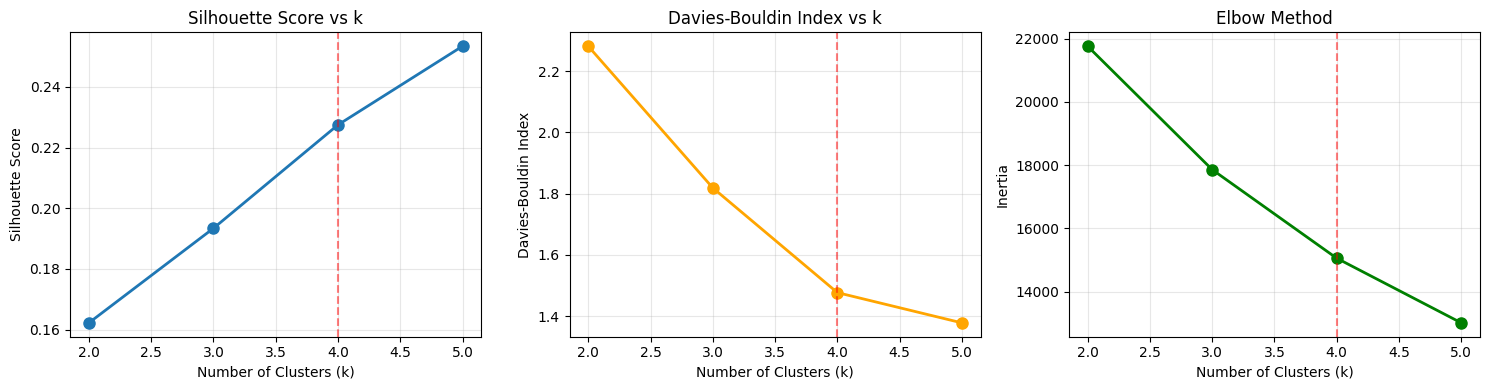


分析 k=4 的聚类结果...

状态 0 (117301 个窗口, 26.7%)
  unique_apis    :   5.546
  repeat_ratio   :   0.284
  change_rate    :   1.000
  entropy        :   2.323

状态 1 (140836 个窗口, 32.1%)
  unique_apis    :   8.029
  repeat_ratio   :   0.239
  change_rate    :   1.000
  entropy        :   2.889

状态 2 (102132 个窗口, 23.3%)
  unique_apis    :   5.760
  repeat_ratio   :   0.313
  change_rate    :   1.000
  entropy        :   2.335

状态 3 (78491 个窗口, 17.9%)
  unique_apis    :   2.530
  repeat_ratio   :   0.482
  change_rate    :   1.000
  entropy        :   1.191

状态解释...

状态类型:
  状态 0 → Periodic/Maintenance
  状态 1 → High-activity/Stress
  状态 2 → Periodic/Maintenance
  状态 3 → Idle/Low-activity


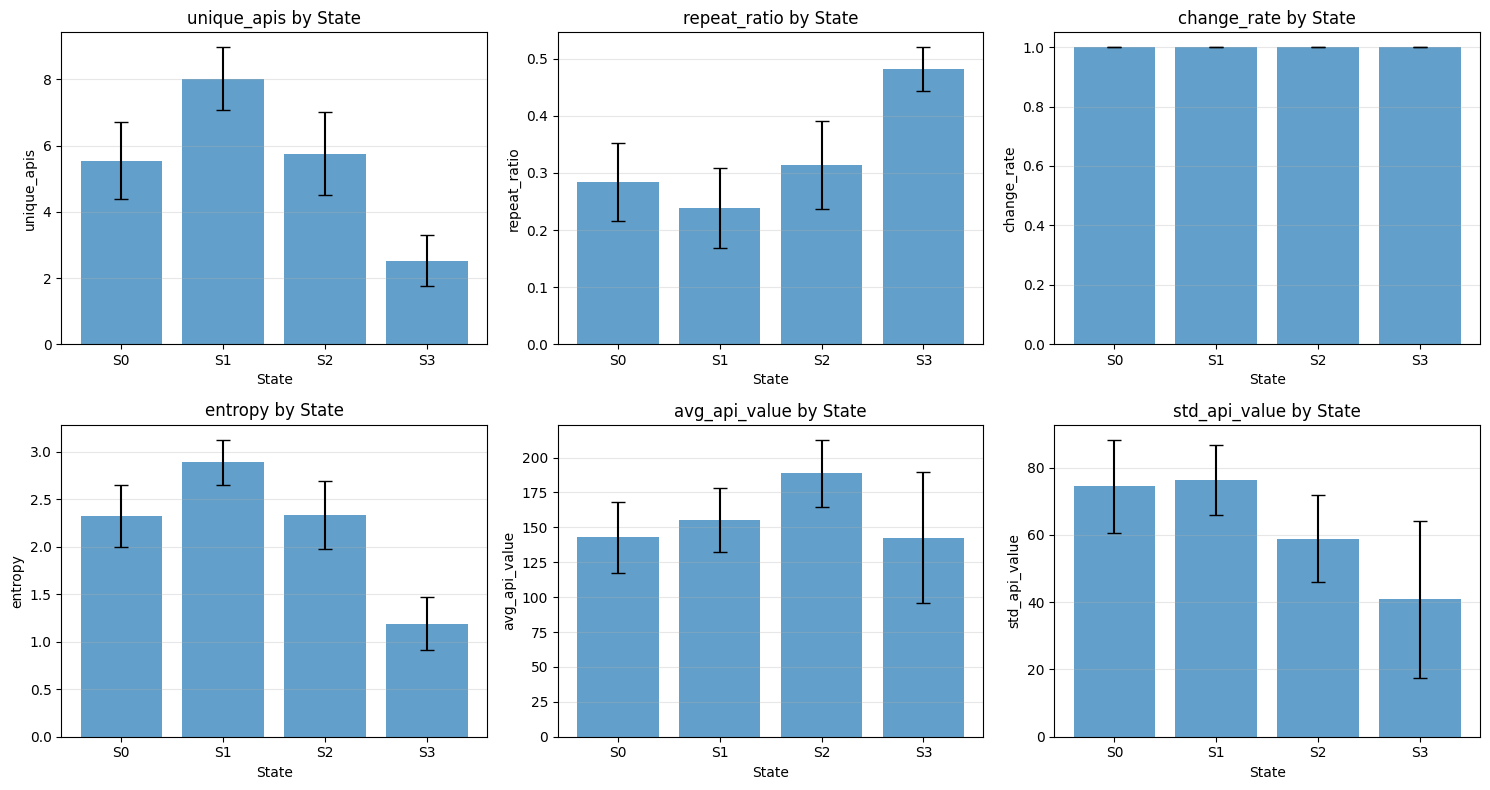


创建状态序列...
✓ 创建了 43876 个样本的状态序列

前3个样本的状态序列:
  样本0: [2 0 3 3 3 1 0 0 1 1]
  样本1: [2 3 3 1 1 1 1 1 2 1]
  样本2: [0 1 2 3 2 1 0 0 0 0]

状态转换分析...



状态转换概率矩阵:
[[0.453 0.243 0.179 0.126]
 [0.274 0.474 0.21  0.042]
 [0.291 0.319 0.3   0.09 ]
 [0.094 0.251 0.137 0.519]]


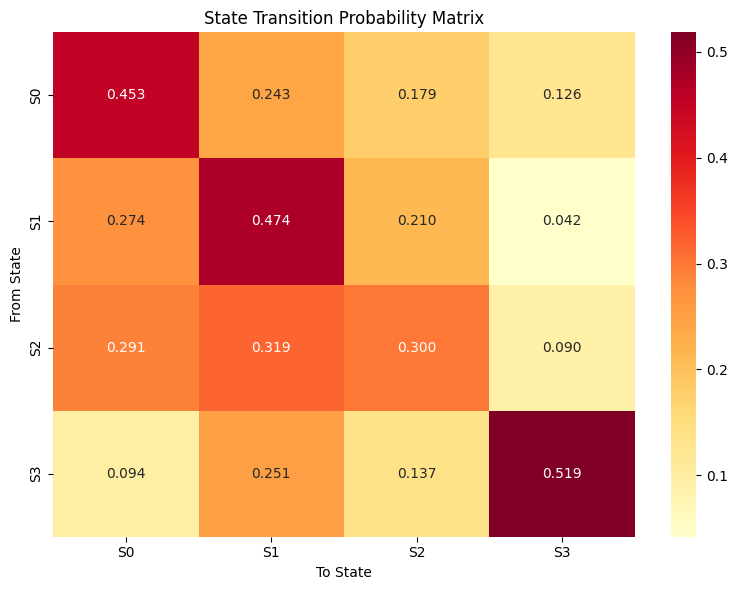


保存结果...
✓ 结果已保存到 'data_with_states_fast.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


快速聚类分析完成！

优化策略:
  - 使用向量化特征提取
  - MiniBatchKMeans替代标准KMeans
  - PCA降维: 7 → 5 维
  - 数据采样: 438760 → 5000 用于聚类

数据集信息:
  - 样本数量: 43876
  - 总窗口数: 438760
  - 聚类数量: 4
  - 轮廓系数: 0.227

状态分布:
  状态0 (Periodic/Maintenance     ): 117301 窗口 ( 26.7%)
  状态1 (High-activity/Stress     ): 140836 窗口 ( 32.1%)
  状态2 (Periodic/Maintenance     ): 102132 窗口 ( 23.3%)
  状态3 (Idle/Low-activity        ): 78491 窗口 ( 17.9%)

✓ 全部完成!


In [4]:
# ========================================
# 优化版本：加速K-means聚类
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print("✓ 库导入成功")

# ========================================
# 1. 上传数据文件
# ========================================
from google.colab import files
print("请上传CSV文件...")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print(f"✓ 文件 '{filename}' 上传成功")

df = pd.read_csv(filename)
print(f"\n数据集形状: {df.shape}")
print(f"样本数量: {len(df)}")

# ========================================
# 2. 快速特征提取（向量化版本）
# ========================================
print("\n========================================")
print("快速特征提取...")

def extract_features_vectorized(df, window_size=10):
    """
    向量化的特征提取，更快速
    """
    all_features = []
    sample_indices = []
    window_indices = []

    # 获取API序列（排除hash和malware列）
    sequences = df.iloc[:, 1:-1].values

    n_samples, seq_len = sequences.shape
    n_windows = seq_len // window_size

    print(f"处理 {n_samples} 个样本, 每个样本 {n_windows} 个窗口...")

    for idx in range(n_samples):
        seq = sequences[idx]

        for w in range(n_windows):
            start = w * window_size
            end = start + window_size
            window = seq[start:end]

            # 快速计算特征
            unique_apis = len(np.unique(window))

            # API重复度
            values, counts = np.unique(window, return_counts=True)
            max_repeat = counts.max()
            repeat_ratio = max_repeat / window_size

            # 变化率
            changes = np.sum(window[1:] != window[:-1])
            change_rate = changes / (window_size - 1)

            # 熵
            probs = counts / window_size
            entropy = -np.sum(probs * np.log2(probs + 1e-10))

            # 统计特征
            avg_api = np.mean(window)
            std_api = np.std(window)

            all_features.append([
                1.0,  # call_rate (固定窗口都是满的)
                unique_apis,
                repeat_ratio,
                change_rate,
                entropy,
                avg_api,
                std_api
            ])

            sample_indices.append(idx)
            window_indices.append(w)

        if (idx + 1) % 10 == 0:
            print(f"  已处理 {idx + 1}/{n_samples} 个样本...")

    return np.array(all_features), sample_indices, window_indices

X_features, sample_idx, window_idx = extract_features_vectorized(df, window_size=10)
print(f"\n✓ 特征提取完成")
print(f"  总窗口数: {len(X_features)}")
print(f"  特征维度: {X_features.shape[1]}")

# ========================================
# 3. 数据采样（可选，进一步加速）
# ========================================
print("\n========================================")
print("数据采样策略...")

# 如果数据量太大，可以先用子集聚类
USE_SAMPLING = len(X_features) > 5000  # 超过5000个窗口时采样

if USE_SAMPLING:
    sample_size = 5000
    print(f"数据量较大({len(X_features)}个窗口)，使用 {sample_size} 个样本进行聚类...")

    # 随机采样
    np.random.seed(42)
    sample_indices_cluster = np.random.choice(len(X_features), sample_size, replace=False)
    X_sample = X_features[sample_indices_cluster]

    print(f"✓ 采样完成，使用 {len(X_sample)} 个样本进行聚类")
else:
    X_sample = X_features
    print(f"数据量适中({len(X_features)}个窗口)，使用全部数据")

# ========================================
# 4. PCA降维（可选，加速聚类）
# ========================================
print("\n========================================")
print("PCA降维...")

USE_PCA = True
n_components = 5  # 从7维降到5维

if USE_PCA:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit(X_sample).transform(X_sample)

    explained_var = pca.explained_variance_ratio_
    cumsum_var = np.cumsum(explained_var)

    print(f"✓ PCA降维完成: {X_sample.shape[1]} → {n_components} 维")
    print(f"  保留方差: {cumsum_var[-1]*100:.2f}%")
    print(f"  各成分方差比例: {explained_var}")

    X_for_clustering = X_pca
else:
    X_for_clustering = X_sample

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_for_clustering)
print("✓ 标准化完成")

# ========================================
# 5. 使用MiniBatchKMeans加速聚类
# ========================================
print("\n========================================")
print("使用MiniBatchKMeans快速聚类...")

k_values = [2, 3, 4, 5]
results = {}

for k in k_values:
    print(f"\n尝试 k={k}...")

    # MiniBatchKMeans比标准KMeans快很多
    kmeans = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        batch_size=1000,  # 批次大小
        n_init=3,  # 减少初始化次数
        max_iter=100,  # 减少最大迭代次数
        verbose=0
    )

    labels = kmeans.fit_predict(X_scaled)

    # 计算评估指标（在采样数据上）
    if len(X_scaled) > 10000:
        # 如果数据太大，只用子集计算silhouette
        eval_indices = np.random.choice(len(X_scaled), 10000, replace=False)
        silhouette = silhouette_score(X_scaled[eval_indices], labels[eval_indices])
        db_score = davies_bouldin_score(X_scaled[eval_indices], labels[eval_indices])
    else:
        silhouette = silhouette_score(X_scaled, labels)
        db_score = davies_bouldin_score(X_scaled, labels)

    results[k] = {
        'model': kmeans,
        'labels': labels,
        'silhouette': silhouette,
        'db_score': db_score,
        'inertia': kmeans.inertia_
    }

    print(f"  轮廓系数: {silhouette:.3f}")
    print(f"  Davies-Bouldin指数: {db_score:.3f}")
    print(f"  簇内平方和: {kmeans.inertia_:.2f}")

k_optimal = 4
state_labels_sample = results[k_optimal]['labels']
kmeans_model = results[k_optimal]['model']

print(f"\n✓ 快速聚类完成！选择 k={k_optimal}")

# ========================================
# 6. 将聚类结果扩展到全部数据
# ========================================
print("\n========================================")
print("将聚类结果扩展到全部数据...")

if USE_SAMPLING:
    # 对全部数据进行预测
    if USE_PCA:
        X_features_pca = pca.transform(X_features)
        X_features_scaled = scaler.transform(X_features_pca)
    else:
        X_features_scaled = scaler.transform(X_features)

    state_labels = kmeans_model.predict(X_features_scaled)
    print(f"✓ 已对全部 {len(state_labels)} 个窗口分配状态")
else:
    state_labels = state_labels_sample
    X_features_scaled = X_scaled

# ========================================
# 7. 快速可视化
# ========================================
print("\n========================================")
print("快速可视化...")

# 评估指标对比
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(k_values, [results[k]['silhouette'] for k in k_values], 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score vs k')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=k_optimal, color='r', linestyle='--', alpha=0.5)

axes[1].plot(k_values, [results[k]['db_score'] for k in k_values], 'o-', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Davies-Bouldin Index')
axes[1].set_title('Davies-Bouldin Index vs k')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=k_optimal, color='r', linestyle='--', alpha=0.5)

axes[2].plot(k_values, [results[k]['inertia'] for k in k_values], 'o-', linewidth=2, markersize=8, color='green')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Inertia')
axes[2].set_title('Elbow Method')
axes[2].grid(True, alpha=0.3)
axes[2].axvline(x=k_optimal, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# ========================================
# 8. 聚类统计（基于原始特征）
# ========================================
print("\n========================================")
print(f"分析 k={k_optimal} 的聚类结果...")

feature_names = ['call_rate', 'unique_apis', 'repeat_ratio', 'change_rate', 'entropy', 'avg_api_value', 'std_api_value']

cluster_stats = []
for i in range(k_optimal):
    cluster_mask = state_labels == i
    cluster_features = X_features[cluster_mask]  # 使用原始特征

    stats = {
        'cluster': i,
        'count': cluster_mask.sum(),
        'percentage': cluster_mask.sum() / len(state_labels) * 100
    }

    for j, fname in enumerate(feature_names):
        stats[f'{fname}_mean'] = cluster_features[:, j].mean()
        stats[f'{fname}_std'] = cluster_features[:, j].std()

    cluster_stats.append(stats)

    print(f"\n状态 {i} ({cluster_mask.sum()} 个窗口, {stats['percentage']:.1f}%)")
    for fname in ['unique_apis', 'repeat_ratio', 'change_rate', 'entropy']:
        mean_val = stats[f'{fname}_mean']
        print(f"  {fname:15s}: {mean_val:7.3f}")

# ========================================
# 9. 状态解释
# ========================================
print("\n========================================")
print("状态解释...")

def interpret_state(stats):
    unique_apis = stats['unique_apis_mean']
    repeat_ratio = stats['repeat_ratio_mean']
    change_rate = stats['change_rate_mean']
    entropy = stats['entropy_mean']

    if entropy < 2.0 and unique_apis < 5:
        return "Idle/Low-activity"
    elif repeat_ratio > 0.4 and change_rate < 0.4:
        return "Steady-service"
    elif unique_apis > 6 and entropy > 2.5:
        return "High-activity/Stress"
    else:
        return "Periodic/Maintenance"

state_interpretations = {}
print("\n状态类型:")
for i in range(k_optimal):
    state_type = interpret_state(cluster_stats[i])
    state_interpretations[i] = state_type
    print(f"  状态 {i} → {state_type}")

# ========================================
# 10. 特征可视化
# ========================================
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

key_features = ['unique_apis', 'repeat_ratio', 'change_rate', 'entropy', 'avg_api_value', 'std_api_value']

for j, fname in enumerate(key_features):
    means = [cluster_stats[i][f'{fname}_mean'] for i in range(k_optimal)]
    stds = [cluster_stats[i][f'{fname}_std'] for i in range(k_optimal)]

    x_pos = range(k_optimal)
    axes[j].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
    axes[j].set_xlabel('State')
    axes[j].set_ylabel(fname)
    axes[j].set_title(f'{fname} by State')
    axes[j].set_xticks(x_pos)
    axes[j].set_xticklabels([f'S{i}' for i in range(k_optimal)])
    axes[j].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ========================================
# 11. 创建状态序列
# ========================================
print("\n========================================")
print("创建状态序列...")

def create_state_sequences_fast(df, state_labels, sample_indices, window_indices):
    state_sequences = {}

    # 转换为numpy数组加速
    sample_arr = np.array(sample_indices)
    window_arr = np.array(window_indices)

    for sample_id in range(len(df)):
        mask = sample_arr == sample_id
        states = state_labels[mask]
        windows = window_arr[mask]

        sorted_idx = np.argsort(windows)
        state_seq = states[sorted_idx]

        state_sequences[sample_id] = state_seq

    return state_sequences

state_seqs = create_state_sequences_fast(df, state_labels, sample_idx, window_idx)
print(f"✓ 创建了 {len(state_seqs)} 个样本的状态序列")

print("\n前3个样本的状态序列:")
for i in range(min(3, len(state_seqs))):
    seq = state_seqs[i]
    print(f"  样本{i}: {seq}")

# ========================================
# 12. 状态转换分析
# ========================================
print("\n========================================")
print("状态转换分析...")

transition_matrix = np.zeros((k_optimal, k_optimal))

for seq in state_seqs.values():
    for i in range(len(seq) - 1):
        transition_matrix[seq[i], seq[i+1]] += 1

# 归一化
row_sums = transition_matrix.sum(axis=1, keepdims=True)
transition_probs = np.divide(transition_matrix, row_sums, where=row_sums!=0)

print("\n状态转换概率矩阵:")
print(transition_probs.round(3))

# 可视化
plt.figure(figsize=(8, 6))
sns.heatmap(transition_probs, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=[f'S{i}' for i in range(k_optimal)],
            yticklabels=[f'S{i}' for i in range(k_optimal)])
plt.title('State Transition Probability Matrix')
plt.xlabel('To State')
plt.ylabel('From State')
plt.tight_layout()
plt.show()

# ========================================
# 13. 保存结果
# ========================================
print("\n========================================")
print("保存结果...")

state_seq_str = []
for i in range(len(df)):
    seq = state_seqs[i]
    seq_str = ','.join(map(str, seq))
    state_seq_str.append(seq_str)

df['state_sequence'] = state_seq_str

output_filename = 'data_with_states_fast.csv'
df.to_csv(output_filename, index=False)
print(f"✓ 结果已保存到 '{output_filename}'")

files.download(output_filename)

# ========================================
# 14. 总结
# ========================================
print("\n" + "="*60)
print("快速聚类分析完成！")
print("="*60)
print(f"\n优化策略:")
print(f"  - 使用向量化特征提取")
print(f"  - MiniBatchKMeans替代标准KMeans")
if USE_PCA:
    print(f"  - PCA降维: {X_features.shape[1]} → {n_components} 维")
if USE_SAMPLING:
    print(f"  - 数据采样: {len(X_features)} → {sample_size} 用于聚类")

print(f"\n数据集信息:")
print(f"  - 样本数量: {len(df)}")
print(f"  - 总窗口数: {len(X_features)}")
print(f"  - 聚类数量: {k_optimal}")
print(f"  - 轮廓系数: {results[k_optimal]['silhouette']:.3f}")

print(f"\n状态分布:")
for i in range(k_optimal):
    print(f"  状态{i} ({state_interpretations[i]:25s}): "
          f"{cluster_stats[i]['count']:5d} 窗口 ({cluster_stats[i]['percentage']:5.1f}%)")

print("\n✓ 全部完成!")
